<a href="https://colab.research.google.com/github/adimalhotra11/CryptoPricePrediction/blob/master/crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=1000')


In [3]:
df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
target_col = 'close'

In [4]:
df.head(5)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2019-01-31,3499.78,3422.83,3467.21,37365.70,1.287739e+08,3434.13,direct,
2019-02-01,3478.55,3398.96,3434.13,41976.43,1.444761e+08,3461.63,direct,
2019-02-02,3519.14,3441.21,3461.63,27103.48,9.414419e+07,3508.68,direct,
2019-02-03,3514.43,3424.42,3508.68,23044.88,7.959122e+07,3449.62,direct,
2019-02-04,3470.80,3429.21,3449.62,23959.61,8.228089e+07,3431.24,direct,


In [5]:
df.tail(10)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2021-10-18,62662.72,59925.93,61520.54,50489.09,3.113486e+09,62038.16,direct,
2021-10-19,64468.70,61410.11,62038.16,42983.11,2.706420e+09,64283.97,direct,
2021-10-20,66980.66,63543.70,64283.97,45364.94,2.978059e+09,66021.02,direct,
2021-10-21,66645.73,62076.16,66021.02,62097.42,3.962470e+09,62283.96,direct,
2021-10-22,63731.17,60017.23,62283.96,40476.42,2.504718e+09,60693.59,direct,
2021-10-23,61733.43,59705.11,60693.59,16232.50,9.903601e+08,61313.09,direct,
2021-10-24,61481.25,59529.34,61313.09,19158.07,1.158839e+09,60863.56,direct,
2021-10-25,63709.97,60658.35,60863.56,24693.91,1.549309e+09,63089.04,direct,
2021-10-26,63290.04,59868.68,63089.04,28107.19,1.738003e+09,60315.68,direct,


### I have to get rid of conversionType and conversionSymbol as they are not required.

In [6]:
df = df.drop(["conversionType", "conversionSymbol"], axis = 'columns')


In [7]:
df.head(20)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2019-01-31,3499.78,3422.83,3467.21,37365.70,1.287739e+08,3434.13
2019-02-01,3478.55,3398.96,3434.13,41976.43,1.444761e+08,3461.63
2019-02-02,3519.14,3441.21,3461.63,27103.48,9.414419e+07,3508.68
2019-02-03,3514.43,3424.42,3508.68,23044.88,7.959122e+07,3449.62
2019-02-04,3470.80,3429.21,3449.62,23959.61,8.228089e+07,3431.24
2019-02-05,3447.88,3415.67,3431.24,24459.49,8.404273e+07,3447.66
2019-02-06,3459.33,3362.24,3447.66,44281.79,1.504086e+08,3394.89
2019-02-07,3406.54,3369.10,3394.89,28811.35,9.739090e+07,3375.33
2019-02-08,3735.10,3363.32,3375.33,89444.22,3.170230e+08,3660.03


In [8]:
df.describe()

,high,low,open,volumefrom,volumeto,close
count,1001.000000,1001.000000,1001.000000,1001.000000,1.001000e+03,1001.000000
mean,20900.435724,19638.348462,20291.507702,48197.196484,9.990823e+08,20346.376294
std,18237.071951,17054.966102,17680.225261,32724.066075,1.166094e+09,17713.165728
min,3406.540000,3362.240000,3375.330000,9355.130000,5.672743e+07,3375.330000
25%,8414.240000,8047.730000,8215.110000,27469.690000,2.633903e+08,8223.250000
50%,10578.970000,10101.870000,10365.560000,40370.000000,4.869364e+08,10372.290000
75%,35945.360000,33333.050000,34611.580000,57692.170000,1.388244e+09,34649.840000
max,66980.660000,63543.700000,66021.020000,319316.540000,1.112022e+10,66021.020000


In [9]:
print("Our data starts from:",df.index[0],"and ends at(updated today): ", df.index[-1])

Our data starts from: 2019-01-31 00:00:00 and ends at(updated today):  2021-10-27 00:00:00


In [10]:
def box_plot(x1,label1=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [11]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [12]:
train, test = train_test_split(df, test_size=0.2)

In [13]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

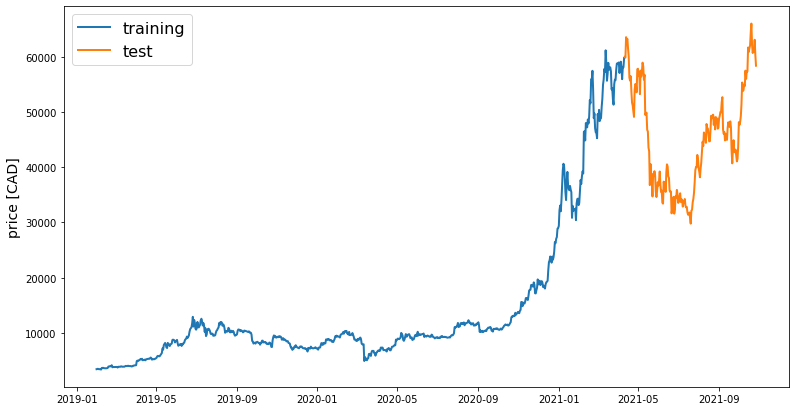

In [14]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [15]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [16]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [17]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [24]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [23]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 50
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [25]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [28]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
25/25 [==============================] - 2s 33ms/step - loss: 0.0053 - val_loss: 0.0035
Epoch 2/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 9/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 10/50
25/25 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 11/50
25/25 

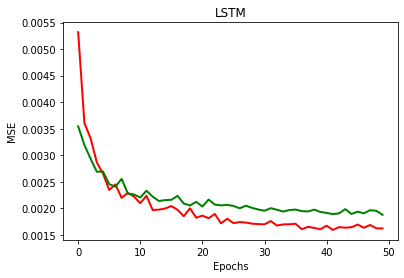

In [29]:
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [31]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mae = mean_absolute_error(preds, y_test)


In [32]:
print("mean absolute error:",mae)

mean absolute error: 0.03317548872255825


In [34]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(preds, y_test)



In [35]:
print("mean squared error:",MSE)

mean squared error: 0.0018773864885904224


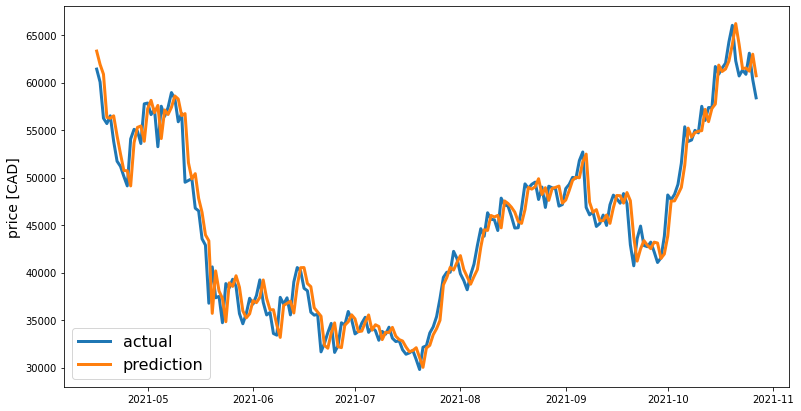

In [37]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)